# Image Model


In [103]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from sklearn.manifold import TSNE
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import json

In [104]:
# Cargar el modelo CLIP y el procesador
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Función para descargar la imagen desde una URL
def download_image(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert("RGB")
    return image

In [105]:
def check_images(data, images_name):
    pages_checked = data
    pages_urls = []
    images_downloaded = []
    relationships = []

    for index, page in enumerate(data):
        relationships.append(len(page[images_name]))
        try: 
            if len(page[images_name]) == 0:
                print("saltada")
                continue

            for image_index, image in enumerate(page[images_name]):
                try:
                    download = download_image(image) 
                    images_downloaded.append(download)
                except:
                    print("No fue posible descargar la imagen. Arreglando")
                    print(index)
                    print(image_index) 
                    pages_checked[index][images_name][image_index] = None
                    continue
            images = [{"index": index, "url": image} for image in pages_checked[index][images_name] if image is not None]
            pages_checked[index][images_name] = [image["url"] for image in images]

            if len(images) > 0:
                pages_urls += images

        except Exception as e:
            print("error al analizar la pagina")
            print(e)
            continue 
    print(f"Imagenes analizadas: {len(pages_urls)}")
    pages_checked = {"pages": pages_checked, "downloaded_images": images_downloaded, "relationships": relationships}
    return pages_checked

In [ ]:
# Get images from fast check 1st

json_data = {}

with open("../fast_check_data/test_1st.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)

json_data_fast_check_1_fixed = check_images(json_data["pages"], "images")

No fue posible descargar la imagen. Arreglando
1
0
saltada
No fue posible descargar la imagen. Arreglando
6
0
saltada
saltada
No fue posible descargar la imagen. Arreglando
18
0
No fue posible descargar la imagen. Arreglando
18
1
No fue posible descargar la imagen. Arreglando
18
2
Imagenes analizadas: 76


In [ ]:
# Get images from fast check 2nd

json_data = {}

with open("../fast_check_data/test_2nd.json", 'r', encoding='utf-8') as file:
    json_data = json.load(file)

json_data_fast_check_2_fixed = check_images(json_data["pages"], "images")

No fue posible descargar la imagen. Arreglando
6
1
No fue posible descargar la imagen. Arreglando
7
0
saltada
Imagenes analizadas: 42


In [182]:
count = 0

print(json_data_fast_check_1_fixed)

for page in json_data_fast_check_1_fixed["pages"]:
    count += len(page["images"])

print(count)

{'pages': [{'newscast': 'www.fastcheck.cl', 'title': '"La palabra indígena está 124 veces en el borrador de la nueva Constitución. La palabra chileno solo 37 veces": #Falso', 'description': 'En redes sociales se afirma que en el borrador de la nueva Constitución, propuesta por la Convención Constitucional, está mencionado 124...hace 28 meses', 'date': '22/02/2024', 'link': 'https://www.fastcheck.cl/2022/05/25/la-palabra-indigena-esta-124-veces-en-el-borrador-de-la-nueva-constitucion-la-palabra-chileno-solo-37-veces-falso/', 'image': 'data:image/gif;base64,R0lGODlhAQABAIAAAP///////yH5BAEKAAEALAAAAAABAAEAAAICTAEAOw==', 'author': 'Fast Check CL', 'text': '\n\nComparte:\nEn redes sociales se afirma que en el borrador de la nueva Constitución, propuesta por la Convención Constitucional, está mencionado 124 veces el término indígena e indígenas y las palabras chileno, chilenos, chilena y chilenas 37 veces. Fast Check CL determinó que esto es falso, pues las palabras indígena e indígenas son 

In [185]:
# images = []
# error_indexes = []

# for page_index, page in enumerate(json_data_fast_check_1_fixed["pages"]):

#     for index, image in enumerate(page["images"]):
#         try:
#             images.append(download_image(image))
#         except:
#             print("Ha ocurrido un error")
#             print(f"pagina: {page_index}")
#             print(f"imagen: {index}")
#             print(f"link: {page['link']}")
#             print("")
#             error_indexes.append(index)
#             continue

with torch.no_grad():
    inputs = processor(images=json_data_fast_check_1_fixed["downloaded_images"], return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    image_embeddings = outputs
    torch.save(image_embeddings, '1st_image_embeddings.pt')

with torch.no_grad():
    inputs = processor(images=json_data_fast_check_2_fixed["downloaded_images"], return_tensors="pt")
    outputs = model.get_image_features(**inputs)
    image_embeddings = outputs
    torch.save(image_embeddings, '2nd_image_embeddings.pt')



In [ ]:
# #Es una lista con la cantidad de imagenes de cada página (en orden)
# relationships = []

# pages = json_data_fast_check_2_fixed["pages"] + json_data_fast_check_1_fixed["images"]

# for page in pages:
#     relationships.append(len(page["images"]))

# #Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.
# cluster_relationships = []
# for index, relation in enumerate(relationships):
#     for i in range(relation):
#         cluster_relationships.append(index)

# print(relationships)

relationships = []

for page in json_data_fast_check_1_fixed["pages"]:
    relationships.append(len(page["images"]))

for page in json_data_fast_check_2_fixed["pages"]:
    relationships.append(len(page["images"]))

# text_relation = np.full(len(relationships), -1)

# text_relation = list(range(42))
text_relation = []

for index, relation in enumerate(relationships):
    if relation == 0:
        text_relation.append(-1)
        continue
    text_relation.append(index)

#Crea una lista de cluster para luego visualizar que imagen pertenece a que noticia.

amount = 0

cluster_relationships = text_relation
for index, relation in enumerate(relationships):
    amount += relation
    if relation == 0:
        continue
    for i in range(relation):
        cluster_relationships.append(index)

print(cluster_relationships)

[0, -1, -1, 3, 4, 5, -1, 7, -1, 9, 10, 11, 12, 13, 14, 15, 16, -1, 18, 19, 20, 21, 22, 23, 24, 25, 26, -1, 28, -1, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 0, 0, 0, 3, 3, 3, 4, 4, 5, 5, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 18, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 28, 30, 30, 30, 31, 31, 32, 32, 33, 33, 34, 35, 36, 37, 37, 37, 38, 38, 39, 39, 40, 41]


In [200]:
image_embeddings_1st = torch.load('image_embeddings.pt')
image_embeddings_2nd = torch.load('2nd_image_embeddings.pt')
text_embeddings_1st = torch.load('1st_text_embeddings.pt')
text_embeddings_2nd = torch.load('2nd_text_embeddings.pt')

# text_embeddings_1st = text_embeddings_1st.tolist()
# image_embeddings_1st = image_embeddings_1st.tolist()

# for text in text_embeddings_2nd.tolist():
#     text_embeddings_1st.append(text)

# for image in image_embeddings_2nd.tolist():
#     image_embeddings_1st.append(image)

pca = PCA(n_components=20, random_state=42)

#Primer Proceso
print("Primer Proceso")

text_embeddings_1st = pca.fit_transform(text_embeddings_1st)
text_embeddings_1st = torch.from_numpy(text_embeddings_1st).float() 

text_embeddings_2nd = pca.fit_transform(text_embeddings_2nd)
text_embeddings_2nd = torch.from_numpy(text_embeddings_2nd).float() 


hybrid_embeddings_1st = torch.cat((text_embeddings_1st, text_embeddings_2nd), dim=0)
print(hybrid_embeddings_1st.shape)
# duplicated_texts = torch.cat([text_embeddings_1st[i].repeat(n, 1) for i, n in enumerate(relationships) if n != 0], dim=0)

#Segundo Proceso
print("Segundo Proceso")

image_embeddings_1st = pca.fit_transform(image_embeddings_1st)
image_embeddings_1st = torch.from_numpy(image_embeddings_1st).float() 

image_embeddings_2nd = pca.fit_transform(image_embeddings_2nd)
image_embeddings_2nd = torch.from_numpy(image_embeddings_2nd).float() 

hybrid_embeddings_2nd = torch.cat((image_embeddings_1st, image_embeddings_2nd), dim=0)
print(hybrid_embeddings_2nd.shape)
# duplicated_texts = torch.cat([text_embeddings_2nd[i].repeat(n, 1) for i, n in enumerate(relationships) if n != 0], dim=0)

#Forma Final
hybrid_embeddings = torch.cat((hybrid_embeddings_1st, hybrid_embeddings_2nd), dim=0)
print(hybrid_embeddings.shape)


Primer Proceso
torch.Size([42, 20])
Segundo Proceso
torch.Size([118, 20])
torch.Size([160, 20])


C:\Users\usuario\AppData\Local\Temp\ipykernel_2144\4279789637.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings_1st = torch.load('image_embeddings.pt')
C:

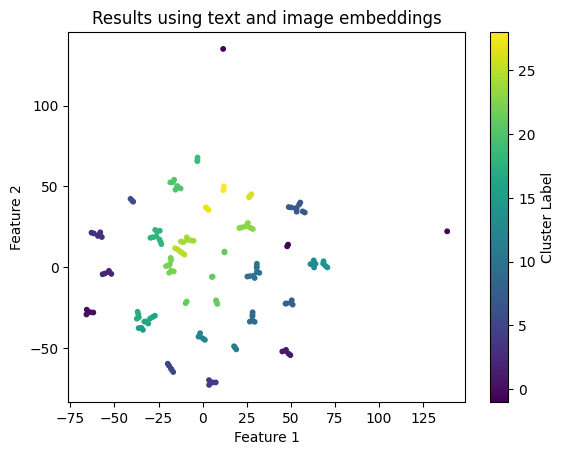

Distancia promedio: 64.89056396484375
Distancia mínima: 0.4802822768688202
Distancia máxima: 210.8520965576172
Silhouette Score: 0.7036110162734985
160
23


In [376]:
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
embeddings_2d = tsne.fit_transform(hybrid_embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=1, cluster_selection_epsilon=3.6)
cluster_labels = clusterer.fit_predict(embeddings_2d)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.title('Results using text and image embeddings')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

distances = pairwise_distances(embeddings_2d, metric='euclidean')
average_distance = np.mean(distances)
min_distance = np.min(distances[distances > 0])
max_distance = np.max(distances)

print(f"Distancia promedio: {average_distance}")
print(f"Distancia mínima: {min_distance}")
print(f"Distancia máxima: {max_distance}")

score = silhouette_score(embeddings_2d, cluster_labels)
print(f"Silhouette Score: {score}")

print(len(embeddings_2d))
print(cluster_labels[11])

160
[9, 28, 61, 65, 66, 67]


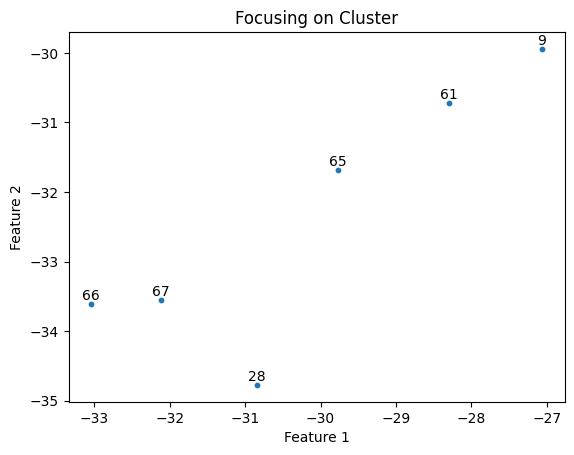

In [379]:

umap_cluster_to_print = 16
facts_selected = []
facts_labels = []

print(len(embeddings_2d))

for index, fact in enumerate(embeddings_2d):
    if cluster_labels[index] == umap_cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

print(facts_labels)

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)

for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

# plt.legend(title="Sites", fontsize=8)
plt.title(f'Focusing on Cluster')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

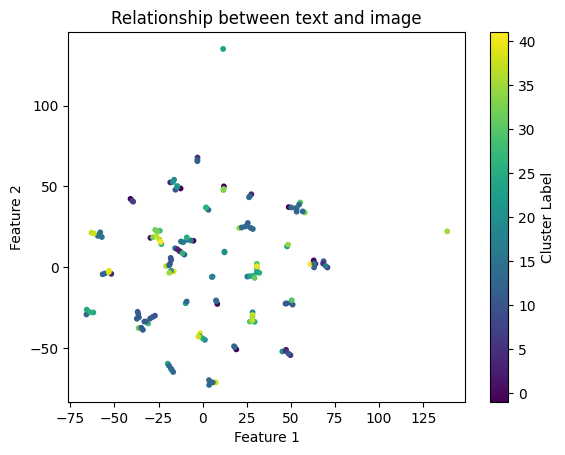

[0, -1, -1, 3, 4, 5, -1, 7, -1, 9, 10, 11, 12, 13, 14, 15, 16, -1, 18, 19, 20, 21, 22, 23, 24, 25, 26, -1, 28, -1, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 0, 0, 0, 3, 3, 3, 4, 4, 5, 5, 7, 7, 9, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 18, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 24, 24, 24, 24, 25, 25, 25, 26, 26, 26, 28, 30, 30, 30, 31, 31, 32, 32, 33, 33, 34, 35, 36, 37, 37, 37, 38, 38, 39, 39, 40, 41]
[{'cluster': 0, 'sum': 4}, {'cluster': -1, 'sum': 7}, {'cluster': 3, 'sum': 4}, {'cluster': 4, 'sum': 3}, {'cluster': 5, 'sum': 3}, {'cluster': 7, 'sum': 3}, {'cluster': 9, 'sum': 2}, {'cluster': 10, 'sum': 4}, {'cluster': 11, 'sum': 17}, {'cluster': 12, 'sum': 3}, {'cluster': 13, 'sum': 31}, {'cluster': 14, 'sum': 2}, {'cluster': 15, 'sum': 6}, {'cluster': 16, 'sum': 5}, {'c

In [377]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_relationships, cmap='viridis', s=10)
plt.title('Relationship between text and image')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

print(cluster_relationships)

repit_list = [{"cluster": cluster_relationships[0], "sum": 0}]


for cluster in cluster_relationships:
    found = False
    for index, repit in enumerate(repit_list):
        if cluster == repit["cluster"]:
            repit_list[index]["sum"] += 1
            found = True
            break
    if not found:
        repit_list.append({"cluster": cluster, "sum": 1})
        found = False
        continue

print(repit_list)
print(len(repit_list))


160
[11, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


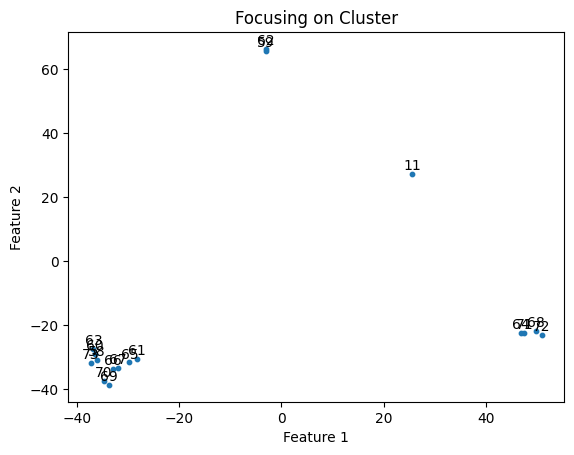

[11] es un texto. Cluster de UMAP [23]
https://www.fastcheck.cl/2020/10/29/no-solo-venezuela-realizo-una-asamblea-constituyente-otros-16-paises-tambien-lo-hicieron-impreciso/
[58] es una imagen. Cluster de UMAP [17]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-16.03.22.png
[59] es una imagen. Cluster de UMAP [19]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-21.46.01.png
[60] es una imagen. Cluster de UMAP [17]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-18.54.15.png
[61] es una imagen. Cluster de UMAP [16]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-16.03.22.png
[62] es una imagen. Cluster de UMAP [19]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-21.46.01.png
[63] es una imagen. Cluster de UMAP [17]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantal

In [378]:

cluster_to_print = 11
facts_selected = []
facts_labels = []

print(len(embeddings_2d))

for index, fact in enumerate(embeddings_2d):
    if cluster_relationships[index] == cluster_to_print:
        facts_selected.append(embeddings_2d[index].tolist())
        facts_labels.append(index)

print(facts_labels)

plt.scatter([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], s=10)

for x, y, etiqueta in zip([fact[0] for fact in facts_selected], [fact[1] for fact in facts_selected], facts_labels):
    plt.annotate(etiqueta, (x, y), textcoords="offset points", xytext=(0, 3), ha='center')

plt.title(f'Focusing on Cluster')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

json_data_combined = json_data_fast_check_1_fixed["pages"] + json_data_fast_check_2_fixed["pages"]
sum = 42

text_index = 0

for data in facts_labels:
    if data < 42:
        if data >= 0 and data <= 9:
            print(f"[0{data}] es un texto. Cluster de UMAP [{cluster_labels[data]}]")
            text_index = data
            print()
        else:
            print(f"[{data}] es un texto. Cluster de UMAP [{cluster_labels[data]}]")
        print(json_data_combined[data]["link"])
    else:
        print(f"[{data}] es una imagen. Cluster de UMAP [{cluster_labels[data]}]")
        for relation in relationships:
            if sum >= data:
                print(json_data_combined[facts_labels[0]]["images"][sum - data])
                break
            sum = sum + relation

[11] es un texto. Cluster de UMAP [24]
https://www.fastcheck.cl/2020/10/29/no-solo-venezuela-realizo-una-asamblea-constituyente-otros-16-paises-tambien-lo-hicieron-impreciso/
[58] es una imagen. Cluster de UMAP [16]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-16.03.22.png
[59] es una imagen. Cluster de UMAP [20]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-21.46.01.png
[60] es una imagen. Cluster de UMAP [16]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-18.54.15.png
[61] es una imagen. Cluster de UMAP [18]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-16.03.22.png
[62] es una imagen. Cluster de UMAP [20]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantalla-2020-10-27-a-las-21.46.01.png
[63] es una imagen. Cluster de UMAP [16]
https://www.fastcheck.cl/wp-content/uploads/2020/10/Captura-de-pantal

In [ ]:
amount = 0

for page in json_data_fast_check_1_fixed["pages"]:
    amount += len(page["images"])
    amount += 1

for page in json_data_fast_check_2_fixed["pages"]:
    amount += len(page["images"])
    amount += 1

print(amount)

42
